**Notebook used to make particle-level evaluation plots**

- Stacked histograms
- Particle pT, eta, phi
- Efficiency and Fake rate

In [2]:
import os, sys
import uproot
import awkward as ak
import vector
import numpy as np
vector.register_awkward()

import boost_histogram as bh
import numba
import mplhep
import sklearn
import sklearn.metrics
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

mplhep.set_style(mplhep.styles.CMS)

/tmp/ipykernel_61865/3051392346.py:17: FutureWarning: ``set_style`` is deprecated: Naming convention is changing to match mpl. Use ``mplhep.style.use()``.
  mplhep.set_style(mplhep.styles.CMS)


In [ ]:
sys.path += ["../../mlpf/plotting//"]
from plot_utils import EVALUATION_DATASET_NAMES, experiment_label
from plot_utils import SAMPLE_LABEL_CMS, pid_to_text, EXPERIMENT_LABELS

In [ ]:
def sample_label(ax, sample, additional_text="", x=0.03, y=0.97, fontsize=20):
    text = EVALUATION_DATASET_NAMES[sample]
    plt.text(x, y, text + additional_text, ha="left", va="top", transform=ax.transAxes, fontsize=fontsize)

def cms_label(ax):
    return experiment_label(ax, experiment="CMS", tag1=" Simulation Preliminary", tag2="Run 3 (14 TeV)", x1=0.13)

In [ ]:
@numba.njit
def deltaphi(phi1, phi2):
    diff = phi1 - phi2
    return np.arctan2(np.sin(diff), np.cos(diff))

@numba.njit
def deltar(eta1, phi1, eta2, phi2):
    deta = eta1 - eta2
    dphi = deltaphi(phi1, phi2)
    return np.sqrt(deta**2 + dphi**2)

@numba.njit
def match_particles(eta1, eta2, phi1, phi2, deltaR_cut):
    nev = len(eta1)
    ptcl_inds_1_ev = []
    ptcl_inds_2_ev = []
    best_drs_ev = []
    for iev in range(nev):
        ptcl_inds_1 = []
        ptcl_inds_2 = []
        best_drs = []

        # loop over the first collection
        pfs_used = np.zeros(len(eta2[iev]))
        for ip1 in range(len(eta1[iev])):
            # compute deltaR from this particle to all particles in the other collection
            drs = 999*np.ones(len(eta2[iev]), dtype=np.float64)

            # loop over the second collection
            for ip2 in range(len(eta2[iev])):
                if pfs_used[ip2]==1:
                    continue
                _eta1 = eta1[iev][ip1]
                _eta2 = eta2[iev][ip2]
                _phi1 = phi1[iev][ip1]
                _phi2 = phi2[iev][ip2]

                dr = deltar(_eta1, _phi1, _eta2, _phi2)
                drs[ip2] = dr

            if len(drs) > 0:
                # find closest match to this particle
                min_idx_dr = np.argmin(drs)

                # has to be closer than the deltaR_cut
                if drs[min_idx_dr] < deltaR_cut:
                    ptcl_inds_1.append(ip1)
                    ptcl_inds_2.append(min_idx_dr)
                    best_drs.append(drs[min_idx_dr])
                    pfs_used[min_idx_dr] = 1
                
        ptcl_inds_1_ev.append(ptcl_inds_1)
        ptcl_inds_2_ev.append(ptcl_inds_2)
        best_drs_ev.append(best_drs)
    return ptcl_inds_1_ev, ptcl_inds_2_ev, best_drs_ev

def sum_overflow_into_last_bin(all_values):
    values = all_values[1:-1]
    values[-1] = values[-1] + all_values[-1]
    values[0] = values[0] + all_values[0]
    return values
    
def to_bh(data, bins, cumulative=False):
    h1 = bh.Histogram(bh.axis.Variable(bins))
    h1.fill(data)
    if cumulative:
        h1[:] = np.sum(h1.values()) - np.cumsum(h1)
    h1[:] = sum_overflow_into_last_bin(h1.values(flow=True)[:])
    return h1

def binom_error(n_sig, n_tot):
    """
    for an efficiency = nSig/nTrueSig or purity = nSig / (nSig + nBckgrd), this function calculates the
    standard deviation according to http://arxiv.org/abs/physics/0701199 .
    """
    variance = np.where(
        n_tot > 0, (n_sig + 1) * (n_sig + 2) / ((n_tot + 2) * (n_tot + 3)) - (n_sig + 1) ** 2 / ((n_tot + 2) ** 2), 0
    )
    return np.sqrt(variance)

def midpoints(x):
    return (x[1:] + x[:-1]) / 2

In [ ]:
! ls ../../data/CMSSW_15_0_5_mlpf_v2.5.0_p04/

In [ ]:
! ls ../../data/CMSSW_15_0_5_mlpf_v2.5.0_p04/TTbar_noPU_mlpfpu/

In [ ]:
dataset = "cms"

save_as = {
    "cms_pf_qcd_nopu": "QCD_noPU",
    "cms_pf_ttbar_nopu": "TTbar_noPU",
}
nfiles = {
    "cms_pf_qcd_nopu": 50,
    "cms_pf_ttbar_nopu": 7,
}

GenCand_fields = [
    "GenCands_pt", "GenCands_eta", "GenCands_phi", "GenCands_mass", "GenCands_pdgId", "GenCands_charge",
]
PFCand_fields = [
    "PFCands_pt", "PFCands_eta", "PFCands_phi", "PFCands_mass", "PFCands_pdgId",
]

Text(1, 0, 'PUPPI weight or PU discr.')

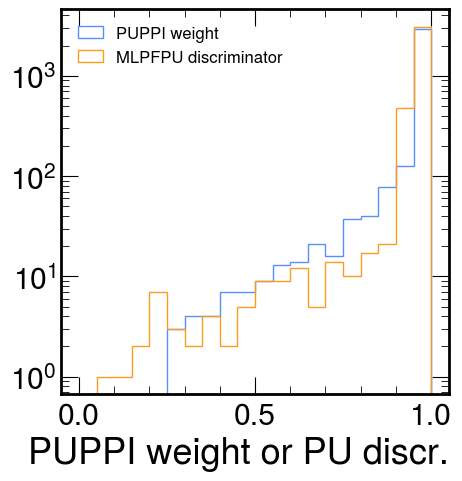

In [22]:
fi1 = uproot.open("/home/joosep/mlpf/results/cms/CMSSW_15_0_5_mlpf_v2.5.0_p01_f8ae2f/cuda_False/TTbar_PU_13p6_pf/step4_NANO_btv_1.root")["Events"]
fi2 = uproot.open("/home/joosep/mlpf/results/cms/CMSSW_15_0_5_mlpf_v2.5.0_p01_f8ae2f/cuda_False/TTbar_PU_13p6_mlpfpu/step4_NANO_btv_1.root")["Events"]
b = np.linspace(0,1,21)
plt.figure(figsize=(5,5))
plt.hist(ak.flatten(fi1["PFCands_puppiWeight"].array()), bins=b, label="PUPPI weight", histtype="step", lw=1);
plt.hist(1.0 - ak.flatten(fi2["PFCands_mlpfpuWeight"].array()), bins=b, label="MLPFPU discriminator", histtype="step", lw=1);
plt.yscale("log")
plt.legend(loc="best", fontsize=12)
plt.xlabel("PUPPI weight or PU discr.")

In [ ]:
##### specify the sample to use
# sample = "cms_pf_ttbar_nopu"
sample = "cms_pf_qcd_nopu"

data_pfs = []
data_mlpfs = []

for ifile in range(1,nfiles[sample]):
    print(ifile)
    ev_pf = uproot.open(f"../../data/CMSSW_15_0_5_mlpf_v2.5.0_p04/{save_as[sample]}_pf/step4_NANO_btv_{ifile}.root").get("Events")
    ev_mlpf = uproot.open(f"../../data/CMSSW_15_0_5_mlpf_v2.5.0_p04/{save_as[sample]}_mlpfpu/step4_NANO_btv_{ifile}.root").get("Events")
    
    # pf
    data_pf = ev_pf.arrays(
        GenCand_fields + PFCand_fields
    )
    data_pfs.append(data_pf)
    
    #mlpf
    data_mlpf = ev_mlpf.arrays(
        GenCand_fields + PFCand_fields
    )
    data_mlpfs.append(data_mlpf)

In [ ]:
data_pf = ak.concatenate(data_pfs)
data_mlpf = ak.concatenate(data_mlpfs)

In [ ]:
def remap_pid(data):
    """
    Gen does not have HF so must remap Reco HF to ch.had or n.had
    """
    pid = np.abs(np.asarray(ak.flatten(data["GenCands_pdgId"])))
    pa = ak.flatten(np.abs(data["GenCands_pdgId"]))
    pc = ak.flatten(np.abs(data["GenCands_charge"]))
    pid[(pa!=11) & (pa!=13) & (pa!=22) & (pc==1)] = 211
    pid[(pa!=11) & (pa!=13) & (pa!=22) & (pc==0)] = 130
    data["GenCands_pid"] = ak.unflatten(pid, ak.count(data["GenCands_pdgId"], axis=1))
    data["PFCands_pid"] = np.abs(data["PFCands_pdgId"])

remap_pid(data_pf)
remap_pid(data_mlpf)

# Plot configs

In [ ]:
color_code = {
    "Gen": "tab:blue",
    "PF": "tab:orange",
    "MLPF": "tab:red",
}

bins_pt = {
    "cms_pf_qcd_nopu": {
        211: np.linspace(0,500,41),
        130: np.linspace(0,200,41),
        22: np.linspace(0,200,41),
        11: np.linspace(0,50,21),
        13: np.linspace(0,50,21),
    },
    "cms_pf_ttbar_nopu": {
        211: np.linspace(0,60,31),
        130: np.linspace(0,40,31),
        22: np.linspace(0,40,31),
        11: np.linspace(0,100,31),
        13: np.linspace(0,100,31),
    },  
}

bins_eta = {
    "cms_pf_qcd_nopu": {
        211: np.linspace(-2.5,2.5,41),
        130: np.linspace(-3,3,41),
        22: np.linspace(-3,3,41),
        11: np.linspace(-2.5,2.5,41),
        13: np.linspace(-2.5,2.5,41),
    },
    "cms_pf_ttbar_nopu": {
        211: np.linspace(-2.5,2.5,41),
        130: np.linspace(-3,3,41),
        22: np.linspace(-3,3,41),
        11: np.linspace(-2.5,2.5,41),
        13: np.linspace(-2.5,2.5,41),
    },
}

bins_phi = {
    "cms_pf_qcd_nopu": {
        211: np.linspace(-3,3,41),
        130: np.linspace(-3,3,41),
        22: np.linspace(-3,3,41),
        11: np.linspace(-3,3,41),
        13: np.linspace(-3,3,41),
    },
    "cms_pf_ttbar_nopu": {
        211: np.linspace(-3,3,41),
        130: np.linspace(-3,3,41),
        22: np.linspace(-3,3,41),
        11: np.linspace(-3,3,21),
        13: np.linspace(-3,3,21),
    },  
}

marker_style = {
    'PF': 's',
    'MLPF': 'o',
}
linestyle = {
    'Gen': '--',
    'PF': ':',
    'MLPF': '-',
}

col_pid = {
    211: "tab:blue",
    130: "tab:orange",
    22: "tab:red",
    11: "tab:green",
    13: "tab:pink",    
}

In [ ]:
os.makedirs(f"./plots/{save_as[sample]}/particle_pt_dist", exist_ok=True)
os.makedirs(f"./plots/{save_as[sample]}/particle_eta_dist", exist_ok=True)
os.makedirs(f"./plots/{save_as[sample]}/particle_phi_dist", exist_ok=True)

os.makedirs(f"./plots/{save_as[sample]}/particle_eff_fakerate_pt", exist_ok=True)
os.makedirs(f"./plots/{save_as[sample]}/particle_eff_fakerate_eta", exist_ok=True)
os.makedirs(f"./plots/{save_as[sample]}/particle_eff_fakerate_phi", exist_ok=True)
os.makedirs(f"./plots/{save_as[sample]}/particle_eff_fakerate_2d", exist_ok=True)

os.makedirs(f"./plots/{save_as[sample]}/particle_ptres", exist_ok=True)
os.makedirs(f"./plots/{save_as[sample]}/particle_dR_circles", exist_ok=True)

# Kinematic distributions

## pT

In [ ]:
ylim_dict = {
    "cms_pf_qcd_nopu": {
        211: 10**8,
        130: 10**7,
        22: 10**8,
        11: 10**6,
        13: 10**4,
    },
    "cms_pf_ttbar_nopu": {
        211: 10**7,
        130: 10**6,
        22: 10**7,
        11: 10**5,
        13: 10**4,
    },    
}

rax_ylim_dict = {
    "cms_pf_qcd_nopu": {
        211: (0,2),
        130: (0,2.2),
        22: (0,4),
        11: (0,8),
        13: (0,4),
    },
    "cms_pf_ttbar_nopu": {
        211: (0.5,1.5),
        130: (0,2),
        22: (0,2.5),
        11: (0,3),
        13: (0,2.4),
    },    
}

for pid in [
    211,
    130,
    22,
    11,
    13,
]:
    fig, (ax, rax) = plt.subplots(
        2, 1, figsize=(10, 10), sharex=True,
        gridspec_kw={"height_ratios": [3, 1], "hspace": 0.05}
    )

    # Extract flattened arrays
    sel = data_pf["GenCands_pid"] == pid
    X_gen = ak.to_numpy(ak.flatten(data_pf["GenCands_pt"][sel]))

    sel = data_pf["PFCands_pid"] == pid
    X_pf = ak.to_numpy(ak.flatten(data_pf["PFCands_pt"][sel]))

    sel = data_mlpf["PFCands_pid"] == pid
    X_mlpf = ak.to_numpy(ak.flatten(data_mlpf["PFCands_pt"][sel]))

    bins = bins_pt[sample][pid]
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    bin_widths = 0.5 * (bins[1:] - bins[:-1])

    # Histograms
    h_gen, _ = np.histogram(X_gen, bins=bins)
    h_pf, _ = np.histogram(X_pf, bins=bins)
    h_mlpf, _ = np.histogram(X_mlpf, bins=bins)

    # Main plot
    ax.hist(bins[:-1], bins=bins, weights=h_gen, histtype="step", lw=2, label="Gen", linestyle="--", color=color_code["Gen"])
    ax.hist(bins[:-1], bins=bins, weights=h_pf, histtype="step", lw=2, label="PF", linestyle="--", color=color_code["PF"])
    ax.hist(bins[:-1], bins=bins, weights=h_mlpf, histtype="step", lw=2, label="MLPF", color=color_code["MLPF"])

    ax.set_yscale("log")
    ax.set_ylabel("Counts")
    ax.set_ylim(1, ylim_dict[sample][pid])
    ax.set_xlim(0)
    ax.legend()
    cms_label(ax)
    if "qcd" in sample:
        sample_label(ax, sample, additional_text=" events", fontsize=24)
    else:
        sample_label(ax, sample, additional_text=" events", fontsize=30)
        
    plt.text(0.03, 0.83, pid_to_text[pid], transform=ax.transAxes, fontsize=20)

    # Ratio + error bars
    ratio_pf = np.divide(h_pf, h_gen, out=np.full_like(h_pf, np.nan, dtype=float), where=h_gen > 0)
    ratio_mlpf = np.divide(h_mlpf, h_gen, out=np.full_like(h_mlpf, np.nan, dtype=float), where=h_gen > 0)

    # Error bars: Poisson error propagation
    err_pf = np.sqrt(h_pf) / h_gen
    err_mlpf = np.sqrt(h_mlpf) / h_gen
    err_pf[h_gen == 0] = np.nan
    err_mlpf[h_gen == 0] = np.nan

    rax.errorbar(bin_centers, ratio_pf, yerr=err_pf, fmt='o', markersize=4, markeredgewidth=1, label="PF", color=color_code["PF"])
    rax.errorbar(bin_centers, ratio_mlpf, yerr=err_mlpf, fmt='o', markersize=4, markeredgewidth=1, label="MLPF", color=color_code["MLPF"])

    rax.axhline(1.0, color="gray", linestyle="--")
    rax.set_ylim(rax_ylim_dict[sample][pid])
    rax.set_ylabel("Ratio")
    
    if sample=="cms_pf_ttbar_nopu":
        if ( (pid==211) ):
            rax.yaxis.set_label_coords(-0.065, 0.7)  # x, y in axis coordinates
        else:
            rax.yaxis.set_label_coords(-0.04, 0.7)  # x, y in axis coordinates
    else:
#         if ( (pid==22) ):
        rax.yaxis.set_label_coords(-0.04, 0.7)  # x, y in axis coordinates    
            
            
    rax.set_xlabel("$p_T$ (GeV)")
    rax.legend(fontsize=20, ncol=2, loc="upper center")

    plt.savefig(f"./plots/{save_as[sample]}/particle_pt_dist/{sample}_pt_{pid}.pdf")

## eta

In [ ]:
ylim_dict = {
    "cms_pf_qcd_nopu": {
        211: 10**7,
        130: 10**6,
        22: 10**7,
        11: 10**4,
        13: 10**3,
    },
    "cms_pf_ttbar_nopu": {
        211: 10**6,
        130: 10**5,
        22: 10**6,
        11: 10**4,
        13: 10**3,
    },    
}

rax_ylim_dict = {
    "cms_pf_qcd_nopu": {
        211: (0.8,1.6),
        130: (0,3),
        22: (0,2),
        11: (0,2.5),
        13: (0,5),
    },
    "cms_pf_ttbar_nopu": {
        211: (0.4,1.6),
        130: (0,2),
        22: (0,1.7),
        11: (0,2),
        13: (0,2),
    },    
}

for pid in [
    211,
    130,
    22,
    11,
    13,
]:
    fig, (ax, rax) = plt.subplots(
        2, 1, figsize=(10, 10), sharex=True,
        gridspec_kw={"height_ratios": [3, 1], "hspace": 0.05}
    )

    # Extract flattened arrays
    sel = data_pf["GenCands_pid"] == pid
    X_gen = ak.to_numpy(ak.flatten(data_pf["GenCands_eta"][sel]))

    sel = data_pf["PFCands_pid"] == pid
    X_pf = ak.to_numpy(ak.flatten(data_pf["PFCands_eta"][sel]))

    sel = data_mlpf["PFCands_pid"] == pid
    X_mlpf = ak.to_numpy(ak.flatten(data_mlpf["PFCands_eta"][sel]))

    bins = bins_eta[sample][pid]
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    bin_widths = 0.5 * (bins[1:] - bins[:-1])

    # Histograms
    h_gen, _ = np.histogram(X_gen, bins=bins)
    h_pf, _ = np.histogram(X_pf, bins=bins)
    h_mlpf, _ = np.histogram(X_mlpf, bins=bins)

    # Main plot
    ax.hist(bins[:-1], bins=bins, weights=h_gen, histtype="step", lw=2, label="Gen", linestyle="--", color=color_code["Gen"])
    ax.hist(bins[:-1], bins=bins, weights=h_pf, histtype="step", lw=2, label="PF", linestyle="--", color=color_code["PF"])
    ax.hist(bins[:-1], bins=bins, weights=h_mlpf, histtype="step", lw=2, label="MLPF", color=color_code["MLPF"])

    ax.set_yscale("log")
    ax.set_ylabel("Counts")
    ax.set_ylim(1, ylim_dict[sample][pid])
    ax.set_xlim(-3,3)
    ax.legend()
    cms_label(ax)
    if "qcd" in sample:
        sample_label(ax, sample, additional_text=" events", fontsize=24)
    else:
        sample_label(ax, sample, additional_text=" events", fontsize=30)
        
    plt.text(0.03, 0.83, pid_to_text[pid], transform=ax.transAxes, fontsize=20)

    # Ratio + error bars
    ratio_pf = np.divide(h_pf, h_gen, out=np.full_like(h_pf, np.nan, dtype=float), where=h_gen > 0)
    ratio_mlpf = np.divide(h_mlpf, h_gen, out=np.full_like(h_mlpf, np.nan, dtype=float), where=h_gen > 0)

    # Error bars: Poisson error propagation
    err_pf = np.sqrt(h_pf) / h_gen
    err_mlpf = np.sqrt(h_mlpf) / h_gen
    err_pf[h_gen == 0] = np.nan
    err_mlpf[h_gen == 0] = np.nan

    rax.errorbar(bin_centers, ratio_pf, yerr=err_pf, fmt='o', markersize=4, markeredgewidth=1, label="PF", color=color_code["PF"])
    rax.errorbar(bin_centers, ratio_mlpf, yerr=err_mlpf, fmt='o', markersize=4, markeredgewidth=1, label="MLPF", color=color_code["MLPF"])

    rax.axhline(1.0, color="gray", linestyle="--")
    rax.set_ylim(rax_ylim_dict[sample][pid])
    rax.set_ylabel("Ratio")
    
    if sample=="cms_pf_qcd_nopu":
        if (pid==211):
            rax.yaxis.set_label_coords(-0.065, 0.7)  # x, y in axis coordinates
        else:
            rax.yaxis.set_label_coords(-0.04, 0.7)  # x, y in axis coordinates

    if sample=="cms_pf_ttbar_nopu":
        if ( (pid==211) ):
            rax.yaxis.set_label_coords(-0.065, 0.7)  # x, y in axis coordinates    
        else:
            rax.yaxis.set_label_coords(-0.04, 0.7)  # x, y in axis coordinates
            
    rax.set_xlabel(r"$\eta$")
    rax.legend(fontsize=20, ncol=2, loc="upper center")

    if pid in [211, 11, 13]:
        plt.xlim(-2.5, 2.5)
        
    plt.savefig(f"./plots/{save_as[sample]}/particle_eta_dist/{sample}_eta_{pid}.pdf")

## phi

In [ ]:
ylim_dict = {
    "cms_pf_qcd_nopu": {
        211: 10**7,
        130: 10**6,
        22: 10**7,
        11: 10**4,
        13: 10**3,
    },
    "cms_pf_ttbar_nopu": {
        211: 10**6,
        130: 10**5,
        22: 10**6,
        11: 10**4,
        13: 10**4,
    },    
}

rax_ylim_dict = {
    "cms_pf_qcd_nopu": {
        211: (0.5,1.5),
        130: (0.5,1.5),
        22: (0,2),
        11: (0,2),
        13: (0,4),
    },
    "cms_pf_ttbar_nopu": {
        211: (0.5,1.6),
        130: (0.3,1.8),
        22: (0,2),
        11: (0,2),
        13: (0.5,1.6),
    },    
}

for pid in [
    211,
    130,
    22,
    11,
    13,
]:
    fig, (ax, rax) = plt.subplots(
        2, 1, figsize=(10, 10), sharex=True,
        gridspec_kw={"height_ratios": [3, 1], "hspace": 0.05}
    )

    # Extract flattened arrays
    sel = data_pf["GenCands_pid"] == pid
    X_gen = ak.to_numpy(ak.flatten(data_pf["GenCands_phi"][sel]))

    sel = data_pf["PFCands_pid"] == pid
    X_pf = ak.to_numpy(ak.flatten(data_pf["PFCands_phi"][sel]))

    sel = data_mlpf["PFCands_pid"] == pid
    X_mlpf = ak.to_numpy(ak.flatten(data_mlpf["PFCands_phi"][sel]))

    bins = bins_phi[sample][pid]
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    bin_widths = 0.5 * (bins[1:] - bins[:-1])

    # Histograms
    h_gen, _ = np.histogram(X_gen, bins=bins)
    h_pf, _ = np.histogram(X_pf, bins=bins)
    h_mlpf, _ = np.histogram(X_mlpf, bins=bins)

    # Main plot
    ax.hist(bins[:-1], bins=bins, weights=h_gen, histtype="step", lw=2, label="Gen", linestyle="--", color=color_code["Gen"])
    ax.hist(bins[:-1], bins=bins, weights=h_pf, histtype="step", lw=2, label="PF", linestyle="--", color=color_code["PF"])
    ax.hist(bins[:-1], bins=bins, weights=h_mlpf, histtype="step", lw=2, label="MLPF", color=color_code["MLPF"])

    ax.set_yscale("log")
    ax.set_ylabel("Counts")
    ax.set_ylim(1, ylim_dict[sample][pid])
    ax.set_xlim(-3,3)
    ax.legend()
    cms_label(ax)
    if "qcd" in sample:
        sample_label(ax, sample, additional_text=" events", fontsize=24)
    else:
        sample_label(ax, sample, additional_text=" events", fontsize=30)
        
    plt.text(0.03, 0.83, pid_to_text[pid], transform=ax.transAxes, fontsize=20)

    # Ratio + error bars
    ratio_pf = np.divide(h_pf, h_gen, out=np.full_like(h_pf, np.nan, dtype=float), where=h_gen > 0)
    ratio_mlpf = np.divide(h_mlpf, h_gen, out=np.full_like(h_mlpf, np.nan, dtype=float), where=h_gen > 0)

    # Error bars: Poisson error propagation
    err_pf = np.sqrt(h_pf) / h_gen
    err_mlpf = np.sqrt(h_mlpf) / h_gen
    err_pf[h_gen == 0] = np.nan
    err_mlpf[h_gen == 0] = np.nan

    rax.errorbar(bin_centers, ratio_pf, yerr=err_pf, fmt='o', markersize=4, markeredgewidth=1, label="PF", color=color_code["PF"])
    rax.errorbar(bin_centers, ratio_mlpf, yerr=err_mlpf, fmt='o', markersize=4, markeredgewidth=1, label="MLPF", color=color_code["MLPF"])

    rax.axhline(1.0, color="gray", linestyle="--")
    rax.set_ylim(rax_ylim_dict[sample][pid])
    rax.set_ylabel("Ratio")

    if sample=="cms_pf_qcd_nopu":
        if ( (pid==211) | (pid==130) ):
            rax.yaxis.set_label_coords(-0.065, 0.7)  # x, y in axis coordinates    
        else:
            rax.yaxis.set_label_coords(-0.04, 0.7)  # x, y in axis coordinates

    if sample=="cms_pf_ttbar_nopu":
        if ( (pid==211) | (pid==130) | (pid==13) ):
            rax.yaxis.set_label_coords(-0.065, 0.7)  # x, y in axis coordinates
        else:
            rax.yaxis.set_label_coords(-0.04, 0.7)  # x, y in axis coordinates  

    rax.set_xlabel(r"$\phi$")
    rax.legend(fontsize=20, ncol=2, loc="upper center")

    plt.savefig(f"./plots/{save_as[sample]}/particle_phi_dist/{sample}_phi_{pid}.pdf")

# Stacked hist

## pT

In [ ]:
ylim_dict = {
    "cms_pf_qcd_nopu": 10**11,
    "cms_pf_ttbar_nopu": 10**9,    
}
bbox_to_anchor_xy = {
    "cms_pf_qcd_nopu": (0.55, 0.92),
    "cms_pf_ttbar_nopu": (0.55, 0.98),
}

bins = np.linspace(0,100,50)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

fig, (ax, rax) = plt.subplots(
    2, 1, figsize=(10, 10), sharex=True,
    gridspec_kw={"height_ratios": [3, 1], "hspace": 0.05}
)

gen_entries = []
pf_entries = []
mlpf_entries = []
for pid in [
    13,
    11,
    130,
    22,    
    211,
]:

    # Gen
    sel = data_pf["GenCands_pid"] == pid
    X_gen = ak.to_numpy(ak.flatten(data_pf["GenCands_pt"][sel]))
        
    total_yield = len(X_gen)
    gen_entries.append((total_yield, X_gen, pid_to_text[pid], col_pid[pid]))

    # PF
    sel = data_pf["PFCands_pid"] == pid
    X_pf = ak.to_numpy(ak.flatten(data_pf["PFCands_pt"][sel]))

    total_yield = len(X_pf)
    pf_entries.append((total_yield, X_pf, pid_to_text[pid], col_pid[pid]))
    
    # MLPF
    sel = data_mlpf["PFCands_pid"] == pid
    X_mlpf = ak.to_numpy(ak.flatten(data_mlpf["PFCands_pt"][sel]))
        
    total_yield = len(X_mlpf)
    mlpf_entries.append((total_yield, X_mlpf, pid_to_text[pid], col_pid[pid]))
        
#### Gen legend
gen_data_list = [entry[1] for entry in gen_entries]
gen_labels    = [f"Gen {entry[2]}" for entry in gen_entries]
gen_colors    = [entry[3] for entry in gen_entries]

ax.hist(
    gen_data_list,
    bins=bins,
    stacked=True,
    histtype='stepfilled',
    color=gen_colors,
    label=gen_labels,
    alpha=0.3,
    edgecolor='k',
    linewidth=0.8
)

#### PF legend
pf_data_list = [entry[1] for entry in pf_entries]
pf_labels    = [entry[2] for entry in pf_entries]
pf_colors    = [entry[3] for entry in pf_entries]

for i in range(len(pf_labels)):
    if i == 0:
        cum_sum = pf_data_list[i]
    else:
        cum_sum = np.concatenate([cum_sum,pf_data_list[i]])

    h_pf, _ = np.histogram(cum_sum, bins=bins)
    
    ax.errorbar(
        bin_centers, h_pf, yerr=np.sqrt(h_pf),
        linestyle=linestyle["PF"],
#         fmt=marker_style["PF"], markersize=4, markeredgewidth=1,
        label=f"PF {pf_labels[i]}",
        color=pf_colors[i],
    )

#### MLPF legend
mlpf_data_list = [entry[1] for entry in mlpf_entries]
mlpf_labels    = [entry[2] for entry in mlpf_entries]
mlpf_colors    = [entry[3] for entry in mlpf_entries]

for i in range(len(mlpf_labels)):
    if i == 0:
        cum_sum = mlpf_data_list[i]
    else:
        cum_sum = np.concatenate([cum_sum,mlpf_data_list[i]])

    h_mlpf, _ = np.histogram(cum_sum, bins=bins)
    
    ax.errorbar(
        bin_centers, h_mlpf, yerr=np.sqrt(h_mlpf),
#         linestyle=linestyle["PF"],
        fmt=marker_style["MLPF"], markersize=4, markeredgewidth=1,
        label=f"MLPF {mlpf_labels[i]}",
        color=mlpf_colors[i],
    )

############## add legend
handles, labels = ax.get_legend_handles_labels()

labels_Gen, labels_PF, labels_MLPF = [], [], []
handles_Gen, handles_PF, handles_MLPF = [], [], []
for i, lab in enumerate(labels):
    if lab.startswith("Gen"):
        labels_Gen += [lab.replace("Gen ", "")]
        handles_Gen += [handles[i]]
    if lab.startswith("PF"):
        labels_PF += [lab.replace("PF ", "")]
        handles_PF += [handles[i]]
    if lab.startswith("MLPF"):
        labels_MLPF += [lab.replace("MLPF ", "")]
        handles_MLPF += [handles[i]]        

leg1 = ax.legend(
    handles=handles_Gen,
    labels=labels_Gen,
    title="Gen",
    ncol=1,                  # Two-column layout
    handletextpad=0.5,       # Space between marker and text
    title_fontsize=25,
    fontsize=20,
    bbox_to_anchor=(bbox_to_anchor_xy[sample][0], bbox_to_anchor_xy[sample][1]),
)
ax.add_artist(leg1)

handles_PF.reverse()
labels_PF.reverse()
leg2 = ax.legend(
    handles=handles_PF,
    labels=labels_PF,
    title="PF",
    ncol=1,                  # Two-column layout
    handletextpad=0.5,       # Space between marker and text
    title_fontsize=25,
    fontsize=20,
    bbox_to_anchor=(bbox_to_anchor_xy[sample][0]+0.22*1, bbox_to_anchor_xy[sample][1]),
)
ax.add_artist(leg2)

handles_MLPF.reverse()
labels_MLPF.reverse()
leg3 = ax.legend(
    handles=handles_MLPF,
    labels=labels_MLPF,
    title="MLPF",
    ncol=1,                  # Two-column layout
    handletextpad=0.5,       # Space between marker and text
    title_fontsize=25,    
    fontsize=20,             # Font size of labels
    bbox_to_anchor=(bbox_to_anchor_xy[sample][0]+0.22*2, bbox_to_anchor_xy[sample][1]),   
)
ax.add_artist(leg3)

ax.set_yscale("log")
ax.set_ylabel("Total number of particles / bin")
ax.set_ylim(1, ylim_dict[sample])
ax.set_xlim(0)

cms_label(ax)
sample_label(ax, sample, additional_text=" events", fontsize=30)

########################### Ratio + error bars
for i in range(len(gen_labels)):
    if i == 0:
        cum_sum = gen_data_list[i]
    else:
        cum_sum = np.concatenate([cum_sum,gen_data_list[i]])
h_gen, _ = np.histogram(cum_sum, bins=bins)

for i in range(len(pf_labels)):
    if i == 0:
        cum_sum = pf_data_list[i]
    else:
        cum_sum = np.concatenate([cum_sum,pf_data_list[i]])
h_pf, _ = np.histogram(cum_sum, bins=bins)
    
for i in range(len(mlpf_labels)):
    if i == 0:
        cum_sum = mlpf_data_list[i]
    else:
        cum_sum = np.concatenate([cum_sum,mlpf_data_list[i]])
h_mlpf, _ = np.histogram(cum_sum, bins=bins)
    
ratio_pf = np.divide(h_pf, h_gen, out=np.full_like(h_pf, np.nan, dtype=float), where=h_gen > 0)
ratio_mlpf = np.divide(h_mlpf, h_gen, out=np.full_like(h_mlpf, np.nan, dtype=float), where=h_gen > 0)

# Error bars: Poisson error propagation
err_pf = np.sqrt(h_pf) / h_gen
err_mlpf = np.sqrt(h_mlpf) / h_gen
err_pf[h_gen == 0] = np.nan
err_mlpf[h_gen == 0] = np.nan

rax.errorbar(bin_centers, ratio_pf, yerr=err_pf, fmt='o', markersize=4, markeredgewidth=1, label="PF", color=color_code["PF"])
rax.errorbar(bin_centers, ratio_mlpf, yerr=err_mlpf, fmt='o', markersize=4, markeredgewidth=1, label="MLPF", color=color_code["MLPF"])

rax.axhline(1.0, color="gray", linestyle="--")
rax.set_ylabel("Reco / Gen")

if sample == "cms_pf_qcd_nopu":
    rax.set_ylim(0.4, 1.6)
    rax.legend(fontsize=20, ncol=2, loc="upper right")
else:
    rax.set_ylim(0,2)
    rax.legend(fontsize=20, ncol=2, loc="upper left")

rax.set_xlabel("Particle $p_T$ (GeV)")

plt.savefig(f"./plots/{save_as[sample]}/particle_pt_dist/{sample}_pt_stacked.pdf")

## eta

In [ ]:
ylim_dict = {
    "cms_pf_qcd_nopu": 10**13,
    "cms_pf_ttbar_nopu": 10**10,    
}
bbox_to_anchor_xy = {
    "cms_pf_qcd_nopu": (0.25, 0.4),
    "cms_pf_ttbar_nopu": (0.25, 0.45),
}

bins = np.linspace(-3,3,50)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

fig, (ax, rax) = plt.subplots(
    2, 1, figsize=(10, 10), sharex=True,
    gridspec_kw={"height_ratios": [3, 1], "hspace": 0.05}
)

gen_entries = []
pf_entries = []
mlpf_entries = []
for pid in [
    13,
    11,
    130,    
    22,
    211,
]:

    # Gen
    sel = data_pf["GenCands_pid"] == pid
    X_gen = ak.to_numpy(ak.flatten(data_pf["GenCands_eta"][sel]))
        
    total_yield = len(X_gen)
    gen_entries.append((total_yield, X_gen, pid_to_text[pid], col_pid[pid]))

    # PF
    sel = data_pf["PFCands_pid"] == pid
    X_pf = ak.to_numpy(ak.flatten(data_pf["PFCands_eta"][sel]))

    total_yield = len(X_pf)
    pf_entries.append((total_yield, X_pf, pid_to_text[pid], col_pid[pid]))
    
    # MLPF
    sel = data_mlpf["PFCands_pid"] == pid
    X_mlpf = ak.to_numpy(ak.flatten(data_mlpf["PFCands_eta"][sel]))
        
    total_yield = len(X_mlpf)
    mlpf_entries.append((total_yield, X_mlpf, pid_to_text[pid], col_pid[pid]))
   
        
#### Gen legend
gen_data_list = [entry[1] for entry in gen_entries]
gen_labels    = [f"Gen {entry[2]}" for entry in gen_entries]
gen_colors    = [entry[3] for entry in gen_entries]

ax.hist(
    gen_data_list,
    bins=bins,
    stacked=True,
    histtype='stepfilled',
    color=gen_colors,
    label=gen_labels,
    alpha=0.3,
    edgecolor='k',
    linewidth=0.8
)

#### PF legend
pf_data_list = [entry[1] for entry in pf_entries]
pf_labels    = [entry[2] for entry in pf_entries]
pf_colors    = [entry[3] for entry in pf_entries]

for i in range(len(pf_labels)):
    if i == 0:
        cum_sum = pf_data_list[i]
    else:
        cum_sum = np.concatenate([cum_sum,pf_data_list[i]])

    h_pf, _ = np.histogram(cum_sum, bins=bins)
    
    ax.errorbar(
        bin_centers, h_pf, yerr=np.sqrt(h_pf),
        linestyle=linestyle["PF"],
#         fmt=marker_style["PF"], markersize=4, markeredgewidth=1,
        label=f"PF {pf_labels[i]}",
        color=pf_colors[i],
    )

#### MLPF legend
mlpf_data_list = [entry[1] for entry in mlpf_entries]
mlpf_labels    = [entry[2] for entry in mlpf_entries]
mlpf_colors    = [entry[3] for entry in mlpf_entries]

for i in range(len(mlpf_labels)):
    if i == 0:
        cum_sum = mlpf_data_list[i]
    else:
        cum_sum = np.concatenate([cum_sum,mlpf_data_list[i]])

    h_mlpf, _ = np.histogram(cum_sum, bins=bins)
    
    ax.errorbar(
        bin_centers, h_mlpf, yerr=np.sqrt(h_mlpf),
#         linestyle=linestyle["PF"],
        fmt=marker_style["MLPF"], markersize=4, markeredgewidth=1,
        label=f"MLPF {mlpf_labels[i]}",
        color=mlpf_colors[i],
    )

############## add legend
handles, labels = ax.get_legend_handles_labels()

labels_Gen, labels_PF, labels_MLPF = [], [], []
handles_Gen, handles_PF, handles_MLPF = [], [], []
for i, lab in enumerate(labels):
    if lab.startswith("Gen"):
        labels_Gen += [lab.replace("Gen ", "")]
        handles_Gen += [handles[i]]
    if lab.startswith("PF"):
        labels_PF += [lab.replace("PF ", "")]
        handles_PF += [handles[i]]
    if lab.startswith("MLPF"):
        labels_MLPF += [lab.replace("MLPF ", "")]
        handles_MLPF += [handles[i]]        

leg1 = ax.legend(
    handles=handles_Gen,
    labels=labels_Gen,
    title="Gen",
    ncol=1,                  # Two-column layout
    handletextpad=0.5,       # Space between marker and text
    title_fontsize=25,
    fontsize=20,
    bbox_to_anchor=(bbox_to_anchor_xy[sample][0], bbox_to_anchor_xy[sample][1]),
)
ax.add_artist(leg1)

handles_PF.reverse()
labels_PF.reverse()
leg2 = ax.legend(
    handles=handles_PF,
    labels=labels_PF,
    title="PF",
    ncol=1,                  # Two-column layout
    handletextpad=0.5,       # Space between marker and text
    title_fontsize=25,
    fontsize=20,
    bbox_to_anchor=(bbox_to_anchor_xy[sample][0]+0.22*1, bbox_to_anchor_xy[sample][1]),
)
ax.add_artist(leg2)

handles_MLPF.reverse()
labels_MLPF.reverse()
leg3 = ax.legend(
    handles=handles_MLPF,
    labels=labels_MLPF,
    title="MLPF",
    ncol=1,                  # Two-column layout
    handletextpad=0.5,       # Space between marker and text
    title_fontsize=25,    
    fontsize=20,             # Font size of labels
    bbox_to_anchor=(bbox_to_anchor_xy[sample][0]+0.22*2, bbox_to_anchor_xy[sample][1]),   
)
ax.add_artist(leg3)

ax.set_yscale("log")
ax.set_ylabel("Total number of particles / bin")
ax.set_ylim(1, ylim_dict[sample])
ax.set_xlim(-3,3)

cms_label(ax)
sample_label(ax, sample, additional_text=" events", fontsize=30)

########################### Ratio + error bars
for i in range(len(gen_labels)):
    if i == 0:
        cum_sum = gen_data_list[i]
    else:
        cum_sum = np.concatenate([cum_sum,gen_data_list[i]])
h_gen, _ = np.histogram(cum_sum, bins=bins)

for i in range(len(pf_labels)):
    if i == 0:
        cum_sum = pf_data_list[i]
    else:
        cum_sum = np.concatenate([cum_sum,pf_data_list[i]])
h_pf, _ = np.histogram(cum_sum, bins=bins)
    
for i in range(len(mlpf_labels)):
    if i == 0:
        cum_sum = mlpf_data_list[i]
    else:
        cum_sum = np.concatenate([cum_sum,mlpf_data_list[i]])
h_mlpf, _ = np.histogram(cum_sum, bins=bins)
    
ratio_pf = np.divide(h_pf, h_gen, out=np.full_like(h_pf, np.nan, dtype=float), where=h_gen > 0)
ratio_mlpf = np.divide(h_mlpf, h_gen, out=np.full_like(h_mlpf, np.nan, dtype=float), where=h_gen > 0)

# Error bars: Poisson error propagation
err_pf = np.sqrt(h_pf) / h_gen
err_mlpf = np.sqrt(h_mlpf) / h_gen
err_pf[h_gen == 0] = np.nan
err_mlpf[h_gen == 0] = np.nan

rax.errorbar(bin_centers, ratio_pf, yerr=err_pf, fmt='o', markersize=4, markeredgewidth=1, label="PF", color=color_code["PF"])
rax.errorbar(bin_centers, ratio_mlpf, yerr=err_mlpf, fmt='o', markersize=4, markeredgewidth=1, label="MLPF", color=color_code["MLPF"])

rax.axhline(1.0, color="gray", linestyle="--")
rax.set_ylabel("Reco / Gen")

if sample == "cms_pf_qcd_nopu":
    rax.set_ylim(0, 2.2)
    rax.legend(fontsize=20, ncol=2, loc="upper center")
else:
    rax.set_ylim(0,2)
    rax.legend(fontsize=20, ncol=2, loc="upper center")

rax.set_xlabel(r"Particle $\eta$")

plt.savefig(f"./plots/{save_as[sample]}/particle_eta_dist/{sample}_eta_stacked.pdf")

## phi

In [ ]:
ylim_dict = {
    "cms_pf_qcd_nopu": 10**13,
    "cms_pf_ttbar_nopu": 10**9,    
}
bbox_to_anchor_xy = {
    "cms_pf_qcd_nopu": (0.25, 0.4),
    "cms_pf_ttbar_nopu": (0.25, 0.45),
}

bins = np.linspace(-3,3,50)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

fig, (ax, rax) = plt.subplots(
    2, 1, figsize=(10, 10), sharex=True,
    gridspec_kw={"height_ratios": [3, 1], "hspace": 0.05}
)

gen_entries = []
pf_entries = []
mlpf_entries = []
for pid in [
    13,
    11,
    130,
    22,    
    211,
]:

    # Gen
    sel = data_pf["GenCands_pid"] == pid
    X_gen = ak.to_numpy(ak.flatten(data_pf["GenCands_phi"][sel]))
    
    total_yield = len(X_gen)
    gen_entries.append((total_yield, X_gen, pid_to_text[pid], col_pid[pid]))

    # PF
    sel = data_pf["PFCands_pid"] == pid
    X_pf = ak.to_numpy(ak.flatten(data_pf["PFCands_phi"][sel]))

    total_yield = len(X_pf)
    pf_entries.append((total_yield, X_pf, pid_to_text[pid], col_pid[pid]))
    
    # MLPF
    sel = data_mlpf["PFCands_pid"] == pid
    X_mlpf = ak.to_numpy(ak.flatten(data_mlpf["PFCands_phi"][sel]))
    
    total_yield = len(X_mlpf)
    mlpf_entries.append((total_yield, X_mlpf, pid_to_text[pid], col_pid[pid]))
        
#### Gen legend
gen_data_list = [entry[1] for entry in gen_entries]
gen_labels    = [f"Gen {entry[2]}" for entry in gen_entries]
gen_colors    = [entry[3] for entry in gen_entries]

ax.hist(
    gen_data_list,
    bins=bins,
    stacked=True,
    histtype='stepfilled',
    color=gen_colors,
    label=gen_labels,
    alpha=0.3,
    edgecolor='k',
    linewidth=0.8
)

#### PF legend
pf_data_list = [entry[1] for entry in pf_entries]
pf_labels    = [entry[2] for entry in pf_entries]
pf_colors    = [entry[3] for entry in pf_entries]

for i in range(len(pf_labels)):
    if i == 0:
        cum_sum = pf_data_list[i]
    else:
        cum_sum = np.concatenate([cum_sum,pf_data_list[i]])

    h_pf, _ = np.histogram(cum_sum, bins=bins)
    
    ax.errorbar(
        bin_centers, h_pf, yerr=np.sqrt(h_pf),
        linestyle=linestyle["PF"],
#         fmt=marker_style["PF"], markersize=4, markeredgewidth=1,
        label=f"PF {pf_labels[i]}",
        color=pf_colors[i],
    )

#### MLPF legend
mlpf_data_list = [entry[1] for entry in mlpf_entries]
mlpf_labels    = [entry[2] for entry in mlpf_entries]
mlpf_colors    = [entry[3] for entry in mlpf_entries]

for i in range(len(mlpf_labels)):
    if i == 0:
        cum_sum = mlpf_data_list[i]
    else:
        cum_sum = np.concatenate([cum_sum,mlpf_data_list[i]])

    h_mlpf, _ = np.histogram(cum_sum, bins=bins)
    
    ax.errorbar(
        bin_centers, h_mlpf, yerr=np.sqrt(h_mlpf),
#         linestyle=linestyle["PF"],
        fmt=marker_style["MLPF"], markersize=4, markeredgewidth=1,
        label=f"MLPF {mlpf_labels[i]}",
        color=mlpf_colors[i],
    )

############## add legend
handles, labels = ax.get_legend_handles_labels()

labels_Gen, labels_PF, labels_MLPF = [], [], []
handles_Gen, handles_PF, handles_MLPF = [], [], []
for i, lab in enumerate(labels):
    if lab.startswith("Gen"):
        labels_Gen += [lab.replace("Gen ", "")]
        handles_Gen += [handles[i]]
    if lab.startswith("PF"):
        labels_PF += [lab.replace("PF ", "")]
        handles_PF += [handles[i]]
    if lab.startswith("MLPF"):
        labels_MLPF += [lab.replace("MLPF ", "")]
        handles_MLPF += [handles[i]]        

leg1 = ax.legend(
    handles=handles_Gen,
    labels=labels_Gen,
    title="Gen",
    ncol=1,                  # Two-column layout
    handletextpad=0.5,       # Space between marker and text
    title_fontsize=25,
    fontsize=20,
    bbox_to_anchor=(bbox_to_anchor_xy[sample][0], bbox_to_anchor_xy[sample][1]),
)
ax.add_artist(leg1)

handles_PF.reverse()
labels_PF.reverse()
leg2 = ax.legend(
    handles=handles_PF,
    labels=labels_PF,
    title="PF",
    ncol=1,                  # Two-column layout
    handletextpad=0.5,       # Space between marker and text
    title_fontsize=25,
    fontsize=20,
    bbox_to_anchor=(bbox_to_anchor_xy[sample][0]+0.22*1, bbox_to_anchor_xy[sample][1]),
)
ax.add_artist(leg2)

handles_MLPF.reverse()
labels_MLPF.reverse()
leg3 = ax.legend(
    handles=handles_MLPF,
    labels=labels_MLPF,
    title="MLPF",
    ncol=1,                  # Two-column layout
    handletextpad=0.5,       # Space between marker and text
    title_fontsize=25,    
    fontsize=20,             # Font size of labels
    bbox_to_anchor=(bbox_to_anchor_xy[sample][0]+0.22*2, bbox_to_anchor_xy[sample][1]),   
)
ax.add_artist(leg3)

ax.set_yscale("log")
ax.set_ylabel("Total number of particles / bin")
ax.set_ylim(1, ylim_dict[sample])
ax.set_xlim(-3,3)

cms_label(ax)
sample_label(ax, sample, additional_text=" events", fontsize=30)

########################### Ratio + error bars
for i in range(len(gen_labels)):
    if i == 0:
        cum_sum = gen_data_list[i]
    else:
        cum_sum = np.concatenate([cum_sum,gen_data_list[i]])
h_gen, _ = np.histogram(cum_sum, bins=bins)

for i in range(len(pf_labels)):
    if i == 0:
        cum_sum = pf_data_list[i]
    else:
        cum_sum = np.concatenate([cum_sum,pf_data_list[i]])
h_pf, _ = np.histogram(cum_sum, bins=bins)
    
for i in range(len(mlpf_labels)):
    if i == 0:
        cum_sum = mlpf_data_list[i]
    else:
        cum_sum = np.concatenate([cum_sum,mlpf_data_list[i]])
h_mlpf, _ = np.histogram(cum_sum, bins=bins)
    
ratio_pf = np.divide(h_pf, h_gen, out=np.full_like(h_pf, np.nan, dtype=float), where=h_gen > 0)
ratio_mlpf = np.divide(h_mlpf, h_gen, out=np.full_like(h_mlpf, np.nan, dtype=float), where=h_gen > 0)

# Error bars: Poisson error propagation
err_pf = np.sqrt(h_pf) / h_gen
err_mlpf = np.sqrt(h_mlpf) / h_gen
err_pf[h_gen == 0] = np.nan
err_mlpf[h_gen == 0] = np.nan

rax.errorbar(bin_centers, ratio_pf, yerr=err_pf, fmt='o', markersize=4, markeredgewidth=1, label="PF", color=color_code["PF"])
rax.errorbar(bin_centers, ratio_mlpf, yerr=err_mlpf, fmt='o', markersize=4, markeredgewidth=1, label="MLPF", color=color_code["MLPF"])

rax.axhline(1.0, color="gray", linestyle="--")
rax.set_ylim(0, 2)
rax.set_ylabel("Reco / Gen")

if sample == "cms_pf_qcd_nopu":
    rax.legend(fontsize=20, ncol=2, loc="upper center")
else:
    rax.legend(fontsize=20, ncol=2, loc="upper center")

rax.set_xlabel(r"Particle $\phi$")

plt.savefig(f"./plots/{save_as[sample]}/particle_phi_dist/{sample}_phi_stacked.pdf")

# Matching Gen-to-Reco

## Visualization in dR

In [ ]:
dr_circle_size = 0.15   ###### specify dR threshold
pid = 22
pt_cut = 0.5

iev = 4

plt.figure(figsize=(8,8))
ax = plt.gca()  # Get the current axis to add patches

msk_pid_gen = data_pf["GenCands_pid"] == pid
eta_vals = data_pf["GenCands_eta"][msk_pid_gen][iev]
phi_vals = data_pf["GenCands_phi"][msk_pid_gen][iev]
pt_vals  = data_pf["GenCands_pt"][msk_pid_gen][iev]

eta_vals = eta_vals[pt_vals>pt_cut]
phi_vals = phi_vals[pt_vals>pt_cut]
pt_vals = pt_vals[pt_vals>pt_cut]

plt.scatter(eta_vals, phi_vals, s=pt_vals, color='tab:cyan', label=f'GenCand ({pid_to_text[pid]}, pT>{pt_cut}GeV)')

# Draw ΔR=0.1 cones
for eta, phi in zip(eta_vals, phi_vals):
    circle = Circle((eta, phi), dr_circle_size, color='tab:cyan', alpha=0.3, fill=False, linewidth=1)
    ax.add_patch(circle)

plt.scatter(data_pf["PFCands_eta"][iev], data_pf["PFCands_phi"][iev], s=data_pf["PFCands_pt"][iev], marker="x", color="red", alpha=0.5, label="All PFCands")

plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)
plt.xlabel("η")
plt.ylabel("ϕ")
plt.legend()
plt.title(f"ΔR={dr_circle_size} circles around GenCands", fontsize=20)
plt.grid(True)
plt.tight_layout()
plt.savefig(f"./plots/{save_as[sample]}/particle_dR_circles/gencands_dRcircles_{dr_circle_size}.pdf")

In [ ]:
dr_circle_size = 0.15   ###### specify dR threshold
pid = 22
pt_cut = (0,20)

for iev in range(200):
    
    if iev != 14:
        continue
        
    msk_pid_reco = data_pf["PFCands_pid"] == pid
    eta_vals = data_pf["PFCands_eta"][msk_pid_reco][iev]
    phi_vals = data_pf["PFCands_phi"][msk_pid_reco][iev]
    pt_vals  = data_pf["PFCands_pt"][msk_pid_reco][iev]

    eta_vals = eta_vals[(pt_vals>pt_cut[0]) & (pt_vals<pt_cut[1])]
    phi_vals = phi_vals[(pt_vals>pt_cut[0]) & (pt_vals<pt_cut[1])]
    pt_vals = pt_vals[(pt_vals>pt_cut[0]) & (pt_vals<pt_cut[1])]

    if len(pt_vals) == 0:
        continue
    
    plt.figure(figsize=(8,8))
    ax = plt.gca()  # Get the current axis to add patches
    
    plt.scatter(eta_vals, phi_vals, s=pt_vals, color='red', label=f'PFCand ({pid_to_text[pid]}, {pt_cut[0]}<pT<{pt_cut[1]}GeV)')

    # Draw ΔR=0.1 cones
    for eta, phi in zip(eta_vals, phi_vals):
        circle = Circle((eta, phi), dr_circle_size, color='red', alpha=0.6, fill=False, linewidth=1)
        ax.add_patch(circle)

    plt.scatter(data_pf["GenCands_eta"][iev], data_pf["GenCands_phi"][iev], s=data_pf["GenCands_pt"][iev], marker="x", color="tab:cyan", alpha=0.9, label="All GenCands")
    
    plt.xlim(-3.5, 3.5)
    plt.ylim(-3.5, 3.5)
    plt.xlabel("η")
    plt.ylabel("ϕ")
    plt.legend()
    plt.title(f"ΔR={dr_circle_size} circles around PFCands", fontsize=20)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"./plots/{save_as[sample]}/particle_dR_circles/pfcands_dRcircles_{dr_circle_size}.pdf")

# Make particle-level plots

In [ ]:
# must define matching condition
dR_cut = 0.15
pt_cut = 0.5
eta_cut = float('inf')

# define baseline kinematic cuts
msk_pf_gen_pt = data_pf["GenCands_pt"] > pt_cut
msk_pf_gen_eta = (abs(data_pf["GenCands_eta"]) < eta_cut)
msk_pf_gen = msk_pf_gen_pt & msk_pf_gen_eta

msk_pf_reco_pt = data_pf["PFCands_pt"] > pt_cut
msk_pf_reco_eta = (abs(data_pf["PFCands_eta"]) < eta_cut)
msk_pf_reco = msk_pf_reco_pt & msk_pf_reco_eta

# apply baseline kinematic cuts
eta1 = data_pf["GenCands_eta"][msk_pf_gen]
phi1 = data_pf["GenCands_phi"][msk_pf_gen]

eta2 = data_pf["PFCands_eta"][msk_pf_reco]
phi2 = data_pf["PFCands_phi"][msk_pf_reco]

pf_idx1, pf_idx2, pf_dr = match_particles(eta1, eta2, phi1, phi2, dR_cut)

# define baseline kinematic cuts
msk_mlpf_gen_pt = data_mlpf["GenCands_pt"] > pt_cut
msk_mlpf_gen_eta = (abs(data_mlpf["GenCands_eta"]) < eta_cut)
msk_mlpf_gen = msk_mlpf_gen_pt & msk_mlpf_gen_eta

msk_mlpf_reco_pt = data_mlpf["PFCands_pt"] > pt_cut
msk_mlpf_reco_eta = (abs(data_mlpf["PFCands_eta"]) < eta_cut)
msk_mlpf_reco = msk_mlpf_reco_pt & msk_mlpf_reco_eta

# apply baseline kinematic cuts
eta1 = data_mlpf["GenCands_eta"][msk_mlpf_gen]
phi1 = data_mlpf["GenCands_phi"][msk_mlpf_gen]

eta2 = data_mlpf["PFCands_eta"][msk_mlpf_reco]
phi2 = data_mlpf["PFCands_phi"][msk_mlpf_reco]

mlpf_idx1, mlpf_idx2, mlpf_dr = match_particles(eta1, eta2, phi1, phi2, dR_cut)

## Efficiency / Fake rate as a function of pT (1D)

In [ ]:
for pid in [
    211,
    130,
    22,
    11,
    13,
]:

    #pick genparticles, and genparticles matched to reco
    h_pf_gen =            to_bh(ak.flatten(data_pf["GenCands_pt"][msk_pf_gen][data_pf["GenCands_pid"][msk_pf_gen]==pid]), bins=bins_pt[sample][pid])
    h_pf_gen_matched =    to_bh(ak.flatten(data_pf["GenCands_pt"][msk_pf_gen][pf_idx1][data_pf["GenCands_pid"][msk_pf_gen][pf_idx1]==pid]), bins=bins_pt[sample][pid])

    #pick recoparticles, and recoparticles matched to gen
    h_pf_reco =           to_bh(ak.flatten(data_pf["PFCands_pt"][msk_pf_reco][data_pf["PFCands_pid"][msk_pf_reco]==pid]), bins=bins_pt[sample][pid])
    h_pf_reco_matched =   to_bh(ak.flatten(data_pf["PFCands_pt"][msk_pf_reco][pf_idx2][data_pf["PFCands_pid"][msk_pf_reco][pf_idx2]==pid]), bins=bins_pt[sample][pid])
    
    #repeat for mlpf
    h_mlpf_gen =          to_bh(ak.flatten(data_mlpf["GenCands_pt"][msk_mlpf_gen][data_mlpf["GenCands_pid"][msk_mlpf_gen]==pid]), bins=bins_pt[sample][pid])
    h_mlpf_gen_matched =  to_bh(ak.flatten(data_mlpf["GenCands_pt"][msk_mlpf_gen][mlpf_idx1][data_mlpf["GenCands_pid"][msk_mlpf_gen][mlpf_idx1]==pid]), bins=bins_pt[sample][pid])

    h_mlpf_reco =         to_bh(ak.flatten(data_mlpf["PFCands_pt"][msk_mlpf_reco][data_mlpf["PFCands_pid"][msk_mlpf_reco]==pid]), bins=bins_pt[sample][pid])
    h_mlpf_reco_matched = to_bh(ak.flatten(data_mlpf["PFCands_pt"][msk_mlpf_reco][mlpf_idx2][data_mlpf["PFCands_pid"][msk_mlpf_reco][mlpf_idx2]==pid]), bins=bins_pt[sample][pid])

    #eff: fraction of all gen that were reconstructed
    heff_pf = h_pf_gen_matched/h_pf_gen
    #fake: fraction of all reco that were matched to gen
    hfake_pf = (h_pf_reco - h_pf_reco_matched)/h_pf_reco
    
    heff_mlpf = h_mlpf_gen_matched/h_mlpf_gen
    hfake_mlpf = (h_mlpf_reco - h_mlpf_reco_matched)/h_mlpf_reco
    
    #eff plot
    fig = plt.figure()
    ax = plt.axes()
    plt.errorbar(
        midpoints(heff_pf.axes[0].edges), heff_pf.values(), binom_error(h_pf_gen_matched.values(), h_pf_gen.values()), marker=".", label="PF", linestyle="--", color=color_code["PF"],
    )
    
    plt.errorbar(
        midpoints(heff_mlpf.axes[0].edges), heff_mlpf.values(), binom_error(h_mlpf_gen_matched.values(), h_mlpf_gen.values()), marker=".", label="MLPF", color=color_code["MLPF"],
    )
    plt.ylim(0, 1.3)
    plt.ylabel("Efficiency", fontsize=35)
    plt.xlabel("$p_T^{gen}$ (GeV)", fontsize=35)
    plt.legend(loc="best", fontsize=30)
    cms_label(ax)
    if "qcd" in sample:
        sample_label(ax, sample, additional_text=" events", fontsize=24)
    else:
        sample_label(ax, sample, additional_text=" events", fontsize=30)
    plt.text(0.03, 0.87, pid_to_text[pid], transform=ax.transAxes, fontsize=25)
    
    plt.savefig(f"./plots/{save_as[sample]}/particle_eff_fakerate_pt/{sample}_efficiency_pt_{pid}.pdf")
    
    #fake plot
    fig = plt.figure()
    ax = plt.axes()
    plt.errorbar(
        midpoints(hfake_pf.axes[0].edges), hfake_pf.values(), binom_error(h_pf_reco_matched.values(), h_pf_reco.values()), marker=".", label="PF", linestyle="--", color=color_code["PF"],
    )
    plt.errorbar(
        midpoints(hfake_mlpf.axes[0].edges), hfake_mlpf.values(), binom_error(h_mlpf_reco_matched.values(), h_mlpf_reco.values()), marker=".", label="MLPF", color=color_code["MLPF"],
    )
    plt.ylim(0, 1.0)
    plt.ylabel("Fake rate", fontsize=35)
    plt.xlabel("$p_T^{reco}$ (GeV)", fontsize=35)
    plt.legend(loc="best", fontsize=30)
    cms_label(ax)
    if "qcd" in sample:
        sample_label(ax, sample, additional_text=" events", fontsize=24)
    else:
        sample_label(ax, sample, additional_text=" events", fontsize=30)
    plt.text(0.03, 0.87, pid_to_text[pid], transform=ax.transAxes, fontsize=25)
    
    plt.savefig(f"./plots/{save_as[sample]}/particle_eff_fakerate_pt/{sample}_fakerate_pt_{pid}.pdf")

## Efficiency / Fake rate as a function of eta (1D)

In [ ]:
for pid in [
    211,
    130,
    22,
    11,
    13,
]:

    #pick genparticles, and genparticles matched to reco
    h_pf_gen =            to_bh(ak.flatten(data_pf["GenCands_eta"][msk_pf_gen][data_pf["GenCands_pid"][msk_pf_gen]==pid]), bins=bins_eta[sample][pid])
    h_pf_gen_matched =    to_bh(ak.flatten(data_pf["GenCands_eta"][msk_pf_gen][pf_idx1][data_pf["GenCands_pid"][msk_pf_gen][pf_idx1]==pid]), bins=bins_eta[sample][pid])

    #pick recoparticles, and recoparticles matched to gen
    h_pf_reco =           to_bh(ak.flatten(data_pf["PFCands_eta"][msk_pf_reco][data_pf["PFCands_pid"][msk_pf_reco]==pid]), bins=bins_eta[sample][pid])
    h_pf_reco_matched =   to_bh(ak.flatten(data_pf["PFCands_eta"][msk_pf_reco][pf_idx2][data_pf["PFCands_pid"][msk_pf_reco][pf_idx2]==pid]), bins=bins_eta[sample][pid])

    #repeat for mlpf
    h_mlpf_gen =          to_bh(ak.flatten(data_mlpf["GenCands_eta"][msk_mlpf_gen][data_mlpf["GenCands_pid"][msk_mlpf_gen]==pid]), bins=bins_eta[sample][pid])
    h_mlpf_gen_matched =  to_bh(ak.flatten(data_mlpf["GenCands_eta"][msk_mlpf_gen][mlpf_idx1][data_mlpf["GenCands_pid"][msk_mlpf_gen][mlpf_idx1]==pid]), bins=bins_eta[sample][pid])
    h_mlpf_reco =         to_bh(ak.flatten(data_mlpf["PFCands_eta"][msk_mlpf_reco][data_mlpf["PFCands_pid"][msk_mlpf_reco]==pid]), bins=bins_eta[sample][pid])
    h_mlpf_reco_matched = to_bh(ak.flatten(data_mlpf["PFCands_eta"][msk_mlpf_reco][mlpf_idx2][data_mlpf["PFCands_pid"][msk_mlpf_reco][mlpf_idx2]==pid]), bins=bins_eta[sample][pid])

    #eff: fraction of all gen that were reconstructed
    heff_pf = h_pf_gen_matched/h_pf_gen
    #fake: fraction of all reco that were matched to gen
    hfake_pf = (h_pf_reco - h_pf_reco_matched)/h_pf_reco
    
    heff_mlpf = h_mlpf_gen_matched/h_mlpf_gen
    hfake_mlpf = (h_mlpf_reco - h_mlpf_reco_matched)/h_mlpf_reco
    
    #eff plot
    fig = plt.figure()
    ax = plt.axes()
    plt.errorbar(
        midpoints(heff_pf.axes[0].edges), heff_pf.values(), binom_error(h_pf_gen_matched.values(), h_pf_gen.values()), marker=".", label="PF", linestyle="--", color=color_code["PF"],
    )
    
    plt.errorbar(
        midpoints(heff_mlpf.axes[0].edges), heff_mlpf.values(), binom_error(h_mlpf_gen_matched.values(), h_mlpf_gen.values()), marker=".", label="MLPF", color=color_code["MLPF"],
    )
    plt.ylim(0, 1.25)
    plt.ylabel("Efficiency", fontsize=35)
    plt.xlabel("$\eta^{reco}$", fontsize=35)
    plt.legend(loc="best", fontsize=30)
    cms_label(ax)
    if "qcd" in sample:
        sample_label(ax, sample, additional_text=" events", fontsize=24)
    else:
        sample_label(ax, sample, additional_text=" events", fontsize=30)
        
    plt.text(0.03, 0.87, pid_to_text[pid], transform=ax.transAxes, fontsize=25)
        
    plt.savefig(f"./plots/{save_as[sample]}/particle_eff_fakerate_eta/{sample}_efficiency_eta_{pid}.pdf")
    
    #fake plot
    fig = plt.figure()
    ax = plt.axes()
    plt.errorbar(
        midpoints(hfake_pf.axes[0].edges), hfake_pf.values(), binom_error(h_pf_reco_matched.values(), h_pf_reco.values()), marker=".", label="PF", linestyle="--", color=color_code["PF"],
    )
    plt.errorbar(
        midpoints(hfake_mlpf.axes[0].edges), hfake_mlpf.values(), binom_error(h_mlpf_reco_matched.values(), h_mlpf_reco.values()), marker=".", label="MLPF", color=color_code["MLPF"],
    )
    plt.ylim(0, 1.0)
    
    if pid in [211, 11, 13]:
        plt.xlim(-2.5, 2.5)
        
    plt.ylabel("Fake rate", fontsize=35)
    plt.xlabel("$\eta^{reco}$", fontsize=35)
    plt.legend(loc="best", fontsize=30)
    cms_label(ax)
    if "qcd" in sample:
        sample_label(ax, sample, additional_text=" events", fontsize=24)
    else:
        sample_label(ax, sample, additional_text=" events", fontsize=30)
        
    plt.text(0.03, 0.87, pid_to_text[pid], transform=ax.transAxes, fontsize=25)
    
    plt.savefig(f"./plots/{save_as[sample]}/particle_eff_fakerate_eta/{sample}_fakerate_eta_{pid}.pdf")

## Efficiency / Fake rate as a function of phi (1D)

In [ ]:
for pid in [
    211,
    130,
    22,
    11,
    13,
]:

    #pick genparticles, and genparticles matched to reco
    h_pf_gen =            to_bh(ak.flatten(data_pf["GenCands_phi"][msk_pf_gen][data_pf["GenCands_pid"][msk_pf_gen]==pid]), bins=bins_phi[sample][pid])
    h_pf_gen_matched =    to_bh(ak.flatten(data_pf["GenCands_phi"][msk_pf_gen][pf_idx1][data_pf["GenCands_pid"][msk_pf_gen][pf_idx1]==pid]), bins=bins_phi[sample][pid])

    #pick recoparticles, and recoparticles matched to gen
    h_pf_reco =           to_bh(ak.flatten(data_pf["PFCands_phi"][msk_pf_reco][data_pf["PFCands_pid"][msk_pf_reco]==pid]), bins=bins_phi[sample][pid])
    h_pf_reco_matched =   to_bh(ak.flatten(data_pf["PFCands_phi"][msk_pf_reco][pf_idx2][data_pf["PFCands_pid"][msk_pf_reco][pf_idx2]==pid]), bins=bins_phi[sample][pid])

    #repeat for mlpf
    h_mlpf_gen =          to_bh(ak.flatten(data_mlpf["GenCands_phi"][msk_mlpf_gen][data_mlpf["GenCands_pid"][msk_mlpf_gen]==pid]), bins=bins_phi[sample][pid])
    h_mlpf_gen_matched =  to_bh(ak.flatten(data_mlpf["GenCands_phi"][msk_mlpf_gen][mlpf_idx1][data_mlpf["GenCands_pid"][msk_mlpf_gen][mlpf_idx1]==pid]), bins=bins_phi[sample][pid])
    h_mlpf_reco =         to_bh(ak.flatten(data_mlpf["PFCands_phi"][msk_mlpf_reco][data_mlpf["PFCands_pid"][msk_mlpf_reco]==pid]), bins=bins_phi[sample][pid])
    h_mlpf_reco_matched = to_bh(ak.flatten(data_mlpf["PFCands_phi"][msk_mlpf_reco][mlpf_idx2][data_mlpf["PFCands_pid"][msk_mlpf_reco][mlpf_idx2]==pid]), bins=bins_phi[sample][pid])

    #eff: fraction of all gen that were reconstructed
    heff_pf = h_pf_gen_matched/h_pf_gen
    #fake: fraction of all reco that were matched to gen
    hfake_pf = (h_pf_reco - h_pf_reco_matched)/h_pf_reco
    
    heff_mlpf = h_mlpf_gen_matched/h_mlpf_gen
    hfake_mlpf = (h_mlpf_reco - h_mlpf_reco_matched)/h_mlpf_reco
    
    #eff plot
    fig = plt.figure()
    ax = plt.axes()
    plt.errorbar(
        midpoints(heff_pf.axes[0].edges), heff_pf.values(), binom_error(h_pf_gen_matched.values(), h_pf_gen.values()), marker=".", label="PF", linestyle="--", color=color_code["PF"],
    )
    
    plt.errorbar(
        midpoints(heff_mlpf.axes[0].edges), heff_mlpf.values(), binom_error(h_mlpf_gen_matched.values(), h_mlpf_gen.values()), marker=".", label="MLPF", color=color_code["MLPF"],
    )
    plt.ylim(0, 1.3)
    plt.ylabel("Efficiency")
    plt.xlabel("$\phi^{gen}$")
    plt.legend(loc="best")
    cms_label(ax)
    if "qcd" in sample:
        sample_label(ax, sample, additional_text=" events", fontsize=24)
    else:
        sample_label(ax, sample, additional_text=" events", fontsize=30)
    plt.text(0.03, 0.87, pid_to_text[pid], transform=ax.transAxes, fontsize=25)    
    
    plt.savefig(f"./plots/{save_as[sample]}/particle_eff_fakerate_phi/{sample}_efficiency_phi_{pid}.pdf")
    
    #fake plot
    fig = plt.figure()
    ax = plt.axes()
    plt.errorbar(
        midpoints(hfake_pf.axes[0].edges), hfake_pf.values(), binom_error(h_pf_reco_matched.values(), h_pf_reco.values()), marker=".", label="PF", linestyle="--", color=color_code["PF"],
    )
    plt.errorbar(
        midpoints(hfake_mlpf.axes[0].edges), hfake_mlpf.values(), binom_error(h_mlpf_reco_matched.values(), h_mlpf_reco.values()), marker=".", label="MLPF", color=color_code["MLPF"],
    )
    plt.ylim(0, 1)
    plt.ylabel("Fake rate")
    plt.xlabel("$\phi^{reco}$")
    plt.legend(loc="best")
    cms_label(ax)
    
    if "qcd" in sample:
        sample_label(ax, sample, additional_text=" events", fontsize=24)
    else:
        sample_label(ax, sample, additional_text=" events", fontsize=30)

    plt.text(0.03, 0.87, pid_to_text[pid], transform=ax.transAxes, fontsize=25)    
    
    plt.savefig(f"./plots/{save_as[sample]}/particle_eff_fakerate_phi/{sample}_fakerate_phi_{pid}.pdf")

## Efficiency / Fake rate as a function of pT, eta (2D)

In [ ]:
def to_bh2d(x, y, bins):
    """
    Create a 2D boost histogram with optional cumulative sum and overflow handling.

    Args:
        x (array-like): Values for x-axis (e.g., pt).
        y (array-like): Values for y-axis (e.g., eta).
        bins (tuple): A tuple of (x_bins, y_bins) bin edges.

    Returns:
        bh.Histogram: A 2D histogram.
    """
    x_bins, y_bins = bins
    h2 = bh.Histogram(
        bh.axis.Variable(x_bins),
        bh.axis.Variable(y_bins)
    )
    h2.fill(x, y)

    # Merge overflow into last bin
    vals = h2.view(flow=True)
    vals[-1, -1] += vals[-1, -1]  # already last bin includes overflow
    h2[...] = vals

    return h2

In [ ]:
pid = 211

h2d_pf_reco = to_bh2d(
    ak.flatten(data_pf["PFCands_pt"][msk_pf_reco][data_pf["PFCands_pid"][msk_pf_reco]==pid]),
    ak.flatten(data_pf["PFCands_eta"][msk_pf_reco][data_pf["PFCands_pid"][msk_pf_reco]==pid]),
    bins=(bins_pt[sample][pid], bins_eta[sample][pid]),
)

h2d_pf_reco_matched = to_bh2d(
    ak.flatten(data_pf["PFCands_pt"][msk_pf_reco][pf_idx2][data_pf["PFCands_pid"][msk_pf_reco][pf_idx2]==pid]),
    ak.flatten(data_pf["PFCands_eta"][msk_pf_reco][pf_idx2][data_pf["PFCands_pid"][msk_pf_reco][pf_idx2]==pid]),
    bins=(bins_pt[sample][pid], bins_eta[sample][pid]),
)

h2dfake_pf = (h2d_pf_reco - h2d_pf_reco_matched)/h2d_pf_reco

# Get bin edges
pt_edges = h2dfake_pf.axes[0].edges  # shape (41,)
eta_edges = h2dfake_pf.axes[1].edges  # shape (31,)

# Get the values
fake_vals = h2dfake_pf.view(flow=False)  # shape (40, 30) → (pt_bins-1, eta_bins-1)

# Make meshgrid
X, Y = np.meshgrid(pt_edges, eta_edges, indexing='ij')  # shape (41, 31)

# Now everything matches → C.shape = (40,30), X.shape = (41,31)
fig, ax = plt.subplots(figsize=(8, 6))
pcm = ax.pcolormesh(X, Y, fake_vals, cmap="viridis", vmin=0, vmax=1, shading="auto")
fig.colorbar(pcm, ax=ax)

ax.set_xlabel(r"$p_T$ (GeV)")
ax.set_ylabel(r"$\eta$")
ax.set_title(f"PF {pid_to_text[pid]} fake rate")
plt.tight_layout()

plt.savefig(f"./plots/{save_as[sample]}/particle_eff_fakerate_2d/PF_{sample}_fakerate_pteta_{pid}.pdf")

In [ ]:
h2d_pf_gen = to_bh2d(
    ak.flatten(data_pf["GenCands_pt"][msk_pf_gen][data_pf["GenCands_pid"][msk_pf_gen]==pid]),
    ak.flatten(data_pf["GenCands_eta"][msk_pf_gen][data_pf["GenCands_pid"][msk_pf_gen]==pid]),
    bins=(bins_pt[sample][pid], bins_eta[sample][pid]),
)

h2d_pf_gen_matched = to_bh2d(
    ak.flatten(data_pf["GenCands_pt"][msk_pf_gen][pf_idx1][data_pf["GenCands_pid"][msk_pf_gen][pf_idx1]==pid]),
    ak.flatten(data_pf["GenCands_eta"][msk_pf_gen][pf_idx1][data_pf["GenCands_pid"][msk_pf_gen][pf_idx1]==pid]),
    bins=(bins_pt[sample][pid], bins_eta[sample][pid]),
)

h2deff_pf = h2d_pf_gen_matched / h2d_pf_gen

# Get bin edges
pt_edges = h2deff_pf.axes[0].edges  # shape (41,)
eta_edges = h2deff_pf.axes[1].edges  # shape (31,)

# Get the values
eff_vals = h2deff_pf.view(flow=False)  # shape (40, 30) → (pt_bins-1, eta_bins-1)

# Make meshgrid
X, Y = np.meshgrid(pt_edges, eta_edges, indexing='ij')  # shape (41, 31)

# Now everything matches → C.shape = (40,30), X.shape = (41,31)
fig, ax = plt.subplots(figsize=(8, 6))
pcm = ax.pcolormesh(X, Y, eff_vals, cmap="viridis", vmin=0, vmax=1, shading="auto")
fig.colorbar(pcm, ax=ax)

ax.set_xlabel(r"$p_T$ (GeV)")
ax.set_ylabel(r"$\eta$")
ax.set_title(f"PF {pid_to_text[pid]} efficiency")
plt.tight_layout()

plt.savefig(f"./plots/{save_as[sample]}/particle_eff_fakerate_2d/PF_{sample}_eff_pteta_{pid}.pdf")

In [ ]:
pid = 211

h2d_mlpf_reco = to_bh2d(
    ak.flatten(data_mlpf["PFCands_pt"][msk_mlpf_reco][data_mlpf["PFCands_pid"][msk_mlpf_reco]==pid]),
    ak.flatten(data_mlpf["PFCands_eta"][msk_mlpf_reco][data_mlpf["PFCands_pid"][msk_mlpf_reco]==pid]),
    bins=(bins_pt[sample][pid], bins_eta[sample][pid]),
)

h2d_mlpf_reco_matched = to_bh2d(
    ak.flatten(data_mlpf["PFCands_pt"][msk_mlpf_reco][mlpf_idx2][data_mlpf["PFCands_pid"][msk_mlpf_reco][mlpf_idx2]==pid]),
    ak.flatten(data_mlpf["PFCands_eta"][msk_mlpf_reco][mlpf_idx2][data_mlpf["PFCands_pid"][msk_mlpf_reco][mlpf_idx2]==pid]),
    bins=(bins_pt[sample][pid], bins_eta[sample][pid]),
)

h2dfake_mlpf = (h2d_mlpf_reco - h2d_mlpf_reco_matched)/h2d_mlpf_reco

# Get bin edges
pt_edges = h2dfake_mlpf.axes[0].edges  # shape (41,)
eta_edges = h2dfake_mlpf.axes[1].edges  # shape (31,)

# Get the values
fake_vals = h2dfake_mlpf.view(flow=False)  # shape (40, 30) → (pt_bins-1, eta_bins-1)

# Make meshgrid
X, Y = np.meshgrid(pt_edges, eta_edges, indexing='ij')  # shape (41, 31)

# Now everything matches → C.shape = (40,30), X.shape = (41,31)
fig, ax = plt.subplots(figsize=(8, 6))
pcm = ax.pcolormesh(X, Y, fake_vals, cmap="viridis", vmin=0, vmax=1, shading="auto")
fig.colorbar(pcm, ax=ax)

ax.set_xlabel(r"$p_T$ (GeV)")
ax.set_ylabel(r"$\eta$")
ax.set_title(f"MLPF {pid_to_text[pid]} fake rate")
plt.tight_layout()

plt.savefig(f"./plots/{save_as[sample]}/particle_eff_fakerate_2d/MLPF_{sample}_fakerate_pteta_{pid}.pdf")

In [ ]:
h2d_mlpf_gen = to_bh2d(
    ak.flatten(data_mlpf["GenCands_pt"][msk_mlpf_gen][data_mlpf["GenCands_pid"][msk_mlpf_gen]==pid]),
    ak.flatten(data_mlpf["GenCands_eta"][msk_mlpf_gen][data_mlpf["GenCands_pid"][msk_mlpf_gen]==pid]),
    bins=(bins_pt[sample][pid], bins_eta[sample][pid]),
)

h2d_mlpf_gen_matched = to_bh2d(
    ak.flatten(data_mlpf["GenCands_pt"][msk_mlpf_gen][mlpf_idx1][data_mlpf["GenCands_pid"][msk_mlpf_gen][mlpf_idx1]==pid]),
    ak.flatten(data_mlpf["GenCands_eta"][msk_mlpf_gen][mlpf_idx1][data_mlpf["GenCands_pid"][msk_mlpf_gen][mlpf_idx1]==pid]),
    bins=(bins_pt[sample][pid], bins_eta[sample][pid]),
)

h2deff_mlpf = h2d_mlpf_gen_matched / h2d_mlpf_gen

# Get bin edges
pt_edges = h2deff_mlpf.axes[0].edges  # shape (41,)
eta_edges = h2deff_mlpf.axes[1].edges  # shape (31,)

# Get the values
eff_vals = h2deff_mlpf.view(flow=False)  # shape (40, 30) → (pt_bins-1, eta_bins-1)

# Make meshgrid
X, Y = np.meshgrid(pt_edges, eta_edges, indexing='ij')  # shape (41, 31)

# Now everything matches → C.shape = (40,30), X.shape = (41,31)
fig, ax = plt.subplots(figsize=(8, 6))
pcm = ax.pcolormesh(X, Y, eff_vals, cmap="viridis", vmin=0, vmax=1, shading="auto")
fig.colorbar(pcm, ax=ax)

ax.set_xlabel(r"$p_T$ (GeV)")
ax.set_ylabel(r"$\eta$")
ax.set_title(f"MLPF {pid_to_text[pid]} efficiency")
plt.tight_layout()

plt.savefig(f"./plots/{save_as[sample]}/particle_eff_fakerate_2d/MLPF_{sample}_eff_pteta_{pid}.pdf")

## pT resolution

In [ ]:
b_dict = {
    "cms_pf_qcd_nopu": {
        211: np.linspace(0,10,200),
        130: np.linspace(0,10,200),
        22: np.linspace(0,20,200),
        11: np.linspace(0,5,100),
        13: np.linspace(0,2,100),
    },
    "cms_pf_ttbar_nopu": {
        211: np.linspace(0,10,200),
        130: np.linspace(0,10,200),
        22: np.linspace(0,10,200),
        11: np.linspace(0,2,100),
        13: np.linspace(0,2,100),
    },    
}

ylim_dict = {
    "cms_pf_qcd_nopu": {
        211: 10**8,
        130: 10**5,
        22: 10**6,
        11: 10**4,
        13: 10**4,
    },
    "cms_pf_ttbar_nopu": {
        211: 10**6,
        130: 10**4,
        22: 10**5,
        11: 10**3,
        13: 10**4,
    },    
}

for pid in [
    211,
    130,
    22,
    11,
    13,
]:
    
    fig = plt.figure()
    ax = plt.axes()
    plt.hist(ak.flatten((data_pf["PFCands_pt"][msk_pf_reco][pf_idx2]/data_pf["GenCands_pt"][msk_pf_gen][pf_idx1])[data_pf["GenCands_pid"][msk_pf_gen][pf_idx1]==pid]), bins=b_dict[sample][pid], histtype="step", lw=2, label="PF", linestyle="--", color=color_code["PF"]);
    plt.hist(ak.flatten((data_mlpf["PFCands_pt"][msk_mlpf_reco][mlpf_idx2]/data_mlpf["GenCands_pt"][msk_mlpf_gen][mlpf_idx1])[data_mlpf["GenCands_pid"][msk_mlpf_gen][mlpf_idx1]==pid]), bins=b_dict[sample][pid], histtype="step",lw=2, label="MLPF", color=color_code["MLPF"]);
    plt.yscale("log")
    plt.ylim(1, ylim_dict[sample][pid])
    plt.xlabel("$p_T^{reco}$ / $p_T^{gen}$")
    plt.legend()
    cms_label(ax)
    if "qcd" in sample:
        sample_label(ax, sample, additional_text=" events", fontsize=24)
    else:
        sample_label(ax, sample, additional_text=" events", fontsize=30)
        
    plt.text(0.03, 0.87, pid_to_text[pid], transform=ax.transAxes, fontsize=25)
    
    plt.savefig(f"./plots/{save_as[sample]}/particle_ptres/{sample}_ptres_{pid}.pdf")